In [1]:
import pandas as pd

df = pd.read_csv('../data/Modelar_UH2022.txt', sep = '|')
df.head()

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
0,0,2019-06-13 08:34:09,369320,0.0,17,0.0
1,0,2019-06-13 17:34:10,369403,0.0,2,0.0
2,0,2019-06-13 18:34:10,369403,0.0,0,0.0
3,0,2019-06-13 04:34:10,369284,0.0,1,0.0
4,0,2019-06-13 14:34:10,369356,0.0,28,0.0


### Como solo hay NAs en las columnas de los decimales los despreciamos y ponemos a 0

In [2]:
df.isna().sum()

ID                        0
SAMPLETIME                0
READINGINTEGER            0
READINGTHOUSANDTH    140056
DELTAINTEGER              0
DELTATHOUSANDTH      140056
dtype: int64

In [3]:
df = df.fillna(0)

### Ligera preparación

- Sumar la parte entera y la decimal de READING y THOUSANDTH
- Separar fecha y hora
- Ordenar por ID y por SAMPLETIME

In [ ]:
df['DELTA'] = [j+(i/100) for (j,i) in zip(df['DELTAINTEGER'].values, df['DELTATHOUSANDTH'].values)]
df['READING'] = [j+(i/100) for (j,i) in zip(df['READINGINTEGER'].values, df['READINGTHOUSANDTH'].values)]

In [4]:
'''
df['DELTA'] = [j+(i/10**(num_digitos_parte_entera(i))) for (j,i) in zip(df['DELTAINTEGER'].values, df['DELTATHOUSANDTH'].values)]
df['READING'] = [j+(i/10**(num_digitos_parte_entera(i))) for (j,i) in zip(df['READINGINTEGER'].values, df['READINGTHOUSANDTH'].values)]
'''

In [5]:
df = df.drop(['READINGINTEGER','READINGTHOUSANDTH','DELTAINTEGER','DELTATHOUSANDTH'], axis=1)
df[['DATE', 'TIME']] = df['SAMPLETIME'].str.split(' ', expand = True)

In [6]:
df = df.sort_values(['ID','SAMPLETIME']).reset_index(drop=True)

In [7]:
df.to_pickle('../data/data_v1.pkl')

In [8]:
df = pd.read_pickle('../data/data_v1.pkl') 

### DELTA y READING

Observando el dataframe parece ser que DELTA es la diferencia entre dos medidas de READING. Veamos en qué proporción de filas se cumple esto.

In [429]:
df[df['ID']==0].head()

,ID,SAMPLETIME,DELTA,READING,DATE,TIME
0,0,2019-06-13 08:34:09,17.0,369320.0,2019-06-13,08:34:09
1,0,2019-06-13 17:34:10,2.0,369403.0,2019-06-13,17:34:10
2,0,2019-06-13 18:34:10,0.0,369403.0,2019-06-13,18:34:10
3,0,2019-06-13 04:34:10,1.0,369284.0,2019-06-13,04:34:10
4,0,2019-06-13 14:34:10,28.0,369356.0,2019-06-13,14:34:10


In [10]:
import numpy as np

delta_equals_reading = np.array([])
for i in df['ID'].unique():
    delta_df = df[df['ID']==i]['DELTA']
    reading_dif_df = df[df['ID']==i]['READING'].diff().fillna(0).round(4)
    delta_equals_reading = np.append(delta_equals_reading, sum(delta_df==reading_dif_df)/len(delta_df))

In [11]:
np.mean(delta_equals_reading)

0.9435250295156983

Parece razonable pensar que es cierto.

### Ver que contadores están totalmente completos (todas las horas para todos los días del año) 

In [140]:
complete = []
len_complete = df[df['ID']==0].shape[0]
for i in df['ID'].unique():
    if df[df['ID']==i].shape[0] == len_complete:
        complete.append(i)

In [141]:
print('Complete:', len(complete),'Incomplete:', len(df['ID'].unique())-len(complete), 'Total:', len(df['ID'].unique())) 
complete_percentages = pd.Series({'Complete':len(complete)/len(df['ID'].unique()), 
                                  'Incomplete':1-len(complete)/len(df['ID'].unique())})
complete_percentages

Complete: 1970 Incomplete: 777 Total: 2747


Complete      0.717146
Incomplete    0.282854
dtype: float64

<AxesSubplot:ylabel='None'>

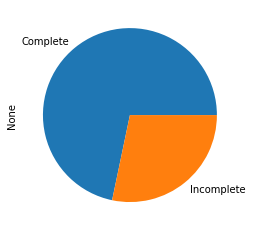

In [142]:
complete_percentages.plot(kind='pie')

### De los completos comprobar que las horas están ordenadas y que la diferencia entre cada medida es aprox. una hora

In [178]:
from datetime import datetime, timedelta

def str2date(string):
    return datetime.strptime(string, '%Y-%m-%d %H:%M:%S')

In [157]:
from tqdm import tqdm

tqdm.pandas()
df['SAMPLETIME'] = df['SAMPLETIME'].progress_apply(str2date)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 21404828/21404828 [04:37<00:00, 77272.26it/s]


In [180]:
a = df[df['ID']==0].sort_values('SAMPLETIME').reset_index(drop=True)

In [184]:
df.head()

,ID,SAMPLETIME,DELTA,READING,DATE,TIME
0,0,2019-02-01 00:39:36,0.0,331710.0,2019-02-01,00:39:36
1,0,2019-02-01 01:39:36,0.0,331710.0,2019-02-01,01:39:36
2,0,2019-02-01 02:39:35,0.0,331710.0,2019-02-01,02:39:35
3,0,2019-02-01 03:39:35,0.0,331710.0,2019-02-01,03:39:35
4,0,2019-02-01 04:39:35,0.0,331710.0,2019-02-01,04:39:35


### Ver cuanto de incompletos están los contadores no completos

In [1]:
365*24

8760

In [143]:
incompleteness = {}
len_complete = 8760
for i in df['ID'].unique():
    if df[df['ID']==i].shape[0] != len_complete:
        incompleteness[i] = len_complete - df[df['ID']==i].shape[0]

In [144]:
incompleteness_serie = pd.Series(incompleteness)

<AxesSubplot:>

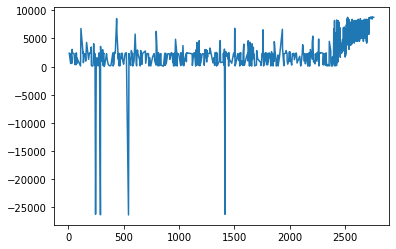

In [145]:
incompleteness_serie.plot()

In [262]:
undercomplete_rate = (incompleteness_serie[incompleteness_serie>0])/len_complete

<AxesSubplot:>

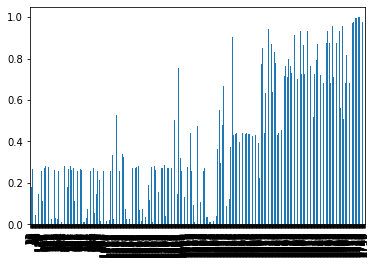

In [264]:
undercomplete_rate.plot(kind='bar')

In [330]:
incomplete_clasif = {}
incomplete_clasif['0-10% missing data'] = len(undercomplete_rate[undercomplete_rate <= 0.1])
incomplete_clasif['10-50% missing data'] = len(undercomplete_rate[(undercomplete_rate > 0.1) & (undercomplete_rate <= 0.5)])
incomplete_clasif['50-80% missing data'] = len(undercomplete_rate[(undercomplete_rate > 0.5) & (undercomplete_rate <= 0.8)])
incomplete_clasif['80-100% missing data'] = len(undercomplete_rate[undercomplete_rate > 0.8])
incomplete_clasif = pd.Series(incomplete_clasif)
incomplete_clasif

0-10% missing data      139
10-50% missing data     374
50-80% missing data     136
80-100% missing data    124
dtype: int64

<AxesSubplot:>

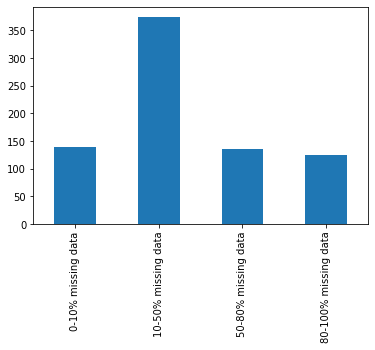

In [331]:
incomplete_clasif.plot(kind='bar')

### Utilidades para analizar el tiempo entre medidas

In [254]:
def average_period(df, i):
    df_sampletimes = df[df['ID']==i]['SAMPLETIME']
    return (df_sampletimes.diff().sum())/len(df_sampletimes)

def num_anormal_gaps(df, i, min_gap=55, max_gap=65):
    sampletimes_difs = df[df['ID']==i]['SAMPLETIME'].diff()
    gaps = 0
    for i,dif in enumerate(sampletimes_difs[1:]):
        if dif < timedelta(minutes = min_gap) or dif > timedelta(minutes = max_gap):
            gaps+=1
    return gaps

In [255]:
average_period(df, 0)

Timedelta('0 days 00:59:59.898276058')

In [256]:
num_anormal_gaps(df,0)

39

### Contadores "sobrecompletos" toman 4 medidas por hora

In [146]:
overcomplete = incompleteness_serie[incompleteness_serie<0]
overcomplete

248    -26197
292    -26295
545    -26317
1416   -26211
dtype: int64

In [189]:
df[df['ID']==0].shape[0]*3

26277

In [195]:
df[df['ID']==248].head()

,ID,SAMPLETIME,DELTA,READING,DATE,TIME
2085142,248,2019-02-01 00:00:00,0.0,20519600.0,2019-02-01,00:00:00
2085143,248,2019-02-01 00:15:00,0.0,20519600.0,2019-02-01,00:15:00
2085144,248,2019-02-01 00:30:00,10.0,20519610.0,2019-02-01,00:30:00
2085145,248,2019-02-01 00:45:00,10.0,20519620.0,2019-02-01,00:45:00
2085146,248,2019-02-01 01:00:00,1500.0,20521120.0,2019-02-01,01:00:00


### No tener en cuenta la hora de las medidas (mala idea porque para cada dia pueden no estar todas las medidas y eso hay que corregirlo)

- Quitar hora
- Agrupar por ID y DATE

In [21]:
df = df.drop(['SAMPLETIME','time'],axis=1)
df = df.groupby(['ID','DATE']).sum().reset_index()
df.head()

,ID,DATE,DELTA,READING
0,0,2019-02-01,243.0,7963359.0
1,0,2019-02-02,236.0,7969096.0
2,0,2019-02-03,335.0,7975263.0
3,0,2019-02-04,252.0,7982426.0
4,0,2019-02-05,220.0,7988972.0


### Breve análisis de los números de los IDs

En efecto, hay 2747 pero sus IDs no son consecutivos sino que hay algunos que se saltan un número al final

In [32]:
len(df['ID'].unique())

2747

In [31]:
df['ID'].unique()[-27:]

array([2720, 2721, 2722, 2723, 2724, 2725, 2727, 2728, 2729, 2730, 2731,
       2732, 2733, 2734, 2735, 2736, 2737, 2739, 2742, 2743, 2744, 2745,
       2746, 2747, 2748, 2749, 2756], dtype=int64)

Contadores que no están:

- 2726
- 2738
- 2740
- 2741
- 2750
- 2751
- 2752
- 2753
- 2754
- 2755

### Análisis número de días sin ninguna medida por contador

In [65]:
def num_days(df, i):
    data_one_id = df[df['ID']==i]
    return len(data_one_id['DATE'].unique())

In [66]:
def missing_dates(df, i):
    all_dates_list = df[df['ID']==0]['DATE'].unique()
    one_id_dates_list = df[df['ID']==i]['DATE'].unique()
    
    missing_dates = []
    for date in all_dates_list:
        if date not in one_id_dates_list:
            missing_dates.append(date)
    return missing_dates

In [75]:
missing={'ID':[],'DATE':[]}
for i in df['ID'].unique():
    if num_days(df, i) != 365:
        missing['ID'].append(i)
        missing['DATE'].append(missing_dates(df, i))

In [76]:
missing_df = pd.DataFrame.from_dict(missing)

In [79]:
missing_df['NUM_MISSINGS'] = missing_df['DATE'].apply(len)

### Índice del contador frente a fechas que faltan para ese contador

<BarContainer object of 772 artists>

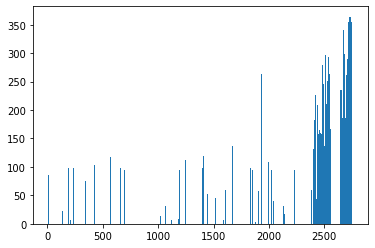

In [85]:
from matplotlib import pyplot as plt

plt.bar(missing_df['ID'], missing_df['NUM_MISSINGS'])

In [90]:
missing_df[missing_df['NUM_MISSINGS'] > 360]

,ID,DATE,NUM_MISSINGS
546,2521,"[2019-02-01, 2019-02-02, 2019-02-03, 2019-02-0...",363
749,2724,"[2019-02-01, 2019-02-02, 2019-02-03, 2019-02-0...",362
750,2725,"[2019-02-01, 2019-02-02, 2019-02-03, 2019-02-0...",362
751,2727,"[2019-02-01, 2019-02-02, 2019-02-03, 2019-02-0...",363
752,2728,"[2019-02-01, 2019-02-02, 2019-02-03, 2019-02-0...",362
753,2729,"[2019-02-01, 2019-02-02, 2019-02-03, 2019-02-0...",364
754,2730,"[2019-02-01, 2019-02-02, 2019-02-03, 2019-02-0...",364
755,2731,"[2019-02-01, 2019-02-02, 2019-02-03, 2019-02-0...",364
756,2732,"[2019-02-01, 2019-02-02, 2019-02-03, 2019-02-0...",364
757,2733,"[2019-02-01, 2019-02-02, 2019-02-03, 2019-02-0...",364
